#### Miroslav Lengyel, 2.3.2024
# Piano MIDI Music generator using LSTM and music21's chordify function<hr>

In [1]:
import os
import tensorflow as tf
import numpy as np
import pickle
import sys
from collections import Counter

from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from keras.layers import LSTM, Input, Dropout, Dense
from keras.layers import concatenate
from keras.models import Model

import music21 as m21
from music21 import note, chord, tempo, stream
from midi2audio import FluidSynth
import matplotlib.pyplot as plt

2024-03-23 16:02:38.752540: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 16:02:38.752628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 16:02:38.797167: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-23 16:02:38.900081: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 16:02:40.102945: W tensorflow/compiler/tf2

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-03-22 16:20:48.138036: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:20:48.291168: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:20:48.291223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.


# 0. Preparation

### 0.1 Run parameters

In [3]:
# directories
input_dir ='__input'
save_dir = '__serialized'
plots_dir ='__plots'
weights_dir = '__weights'

# choose whether songs should be converted or loaded from serialized file
convert_mode = "load"
#convert_mode = "convert"

# model source - start training from scratch or load last checkpoint
model_source = "load"
model_source = "train"

# sequence length for input data, changing this requires converting and training from scratch
seq_len = 64

# constants
notes_per_channel = 128
default_tempo = 100

### 0.2 Helper functions

In [4]:
def serialize_save(input, name):
    with open(os.path.join(save_dir, name), 'wb') as f:
        pickle.dump(input, f) 

def serialize_load(name):
    with open(os.path.join(save_dir, name), 'rb') as f:
        return pickle.load(f)
    
def save_txt(input, filename):
    with open(filename, "w") as txt:
        txt.write(input)

def analyze_durations(chords):
    return sorted(list(Counter([i.duration.quarterLength for i in chords])))

def save_midi_to_file(midi, filename = "output", convert_to_wav = True):
    s = stream.Stream(midi)
    s.write("midi", filename + ".mid")
    if convert_to_wav:
        FluidSynth().midi_to_audio(filename + ".mid", filename + ".wav")
    return s

# 1. Converting classical piano music from MIDI to a format compatible with NN

In this part we are going to convert classical piano compositions from MIDI to a format compatible with neural network.<br>

MIDI contains 16 channels where we can define an instrument for each. MIDI files type 1 and 2 might also contain multiple tracks, with their own channels playing synchronously or asynchronously.<br>

Going with only piano music makes it possible to combine tracks and channels into a single one, drastically reducing dimensionality.<br>

Music21's chordify() function combines all tracks and channels into one, and creates chords from input data. <br>

**The MIDI standard defines 128 possible keys per instrument. Therefore we will represent piano keys and their states as an array 128 ones and zeros.**

**A floating point number will describe the duration of the current chord in whole notes (1.0 for quarter note, 4.0 for whole note, ...)**

### 1.1 MIDI to sequence
- Use music21 chordify() function to convert to keys and durations in quarter notes
- For every chord:
    - Create a row of 128 bytes representing piano keys and their current state (0 - released, 1 - pressed)
    - Append row and duration to array
- Return converted keys and durations

In [5]:
def midi_to_sequence(midi, analyze = False):
    ret_keys = []
    ret_durations = []
    tempo = 0

    chords = m21.converter.parse(midi).chordify()
    if analyze:
        print("Durations:")
        print(analyze_durations(chords.flatten()))

    for i in chords.flatten():  
        if isinstance(i, m21.tempo.MetronomeMark) and tempo == 0:
            tempo = i.number
        elif isinstance(i, m21.note.Note):
            row = np.zeros(notes_per_channel, dtype=np.ubyte)
            if i.isNote:
                row[i.midi] = 1
            ret_keys.append(row)
            ret_durations.append(i.duration.quarterLength)
        elif isinstance(i, m21.chord.Chord):
            row = np.zeros(notes_per_channel, dtype=np.ubyte)
            for pitch in i.pitches:
                row[pitch.midi] = 1
            ret_keys.append(row)
            ret_durations.append(i.duration.quarterLength)

    return ret_keys, ret_durations, tempo

### 1.2 Sequence to MIDI
- For every row in sequence:
    - Get indexes of currently active piano keys
    - Create music21 chord object from indexes
    - Set duration of music21 chord object
    - Append music21 object to array
- Return array

In [6]:
def sequence_to_midi(in_keys, in_durations, tempo = default_tempo):
    ret = [m21.tempo.MetronomeMark(number = tempo)]

    for keys, duration in zip(in_keys, in_durations):
        notes = []
        for note in range(notes_per_channel):
            if keys[note]:
                notes.append(note)
        chord = m21.chord.Chord(notes)
        chord.duration.quarterLength = float(duration)
        ret.append(chord)

    return ret

### 1.3 Sequence padding
Pads the start of a sequence with zeros, will be used later in bulk conversion

In [7]:
def pad_sequence(in_keys, in_durations, padding = seq_len):
    for _ in range(padding):
        in_keys.insert(0, np.zeros(notes_per_channel, dtype=np.ubyte))
        in_durations.insert(0, 0.0)

### 1.4 Conversion test
Optional test to see how well a given song converts to sequence and back to MIDI

In [8]:
def test_conversion(filename):
    keys, durations, tempo = midi_to_sequence(filename, analyze = True)
    pad_sequence(keys, durations)
    midi = sequence_to_midi(keys, durations, tempo)
    print("Durations after conversion:")
    print(analyze_durations(midi))
    save_midi_to_file(midi, "conversion_test")

def test_conversion_multiple(input_directory, output_directory):
    file_list = os.listdir(input_directory)
    file_count = len(file_list)
    for i, file in enumerate(file_list):
        sys.stdout.write(f"{i+1}/{file_count} - {file}\n")
        keys, durations, tempo = midi_to_sequence(os.path.join(input_directory, file), analyze = True)
        pad_sequence(keys, durations)
        midi = sequence_to_midi(keys, durations, tempo)
        print("Durations after conversion:")
        print(analyze_durations(midi))
        save_midi_to_file(midi, os.path.join(output_directory, file.split(".")[0]))

#test_conversion("__input/bach_846.mid")

### 1.5 Bulk convert
Convert all MIDI files in a given directory to sequences, pad them and join together

In [9]:
def bulk_convert(directory):
    ret_keys = []
    ret_durations = []
    print("Converting...")
    file_list = os.listdir(directory)
    file_count = len(file_list)
    for i, file in enumerate(file_list):
        sys.stdout.write(f"\r{i+1}/{file_count} - {file}")
        keys, durations, _ = midi_to_sequence(os.path.join(directory, file))
        pad_sequence(keys, durations)
        ret_keys += keys
        ret_durations += durations

    return ret_keys, ret_durations

### 1.6 Prepare sequences
- For each keys and duration in input arrays:
    - Create an array of *seq_len (64)* sequences, append as input
    - Pick the next sequence and append as output
- Use np.reshape to reshape data into a format that can be used with NN

In [10]:
def prepare_sequences(in_keys, in_durations):
    ret_input_keys = []
    ret_output_keys = []
    ret_input_durations = []
    ret_output_durations = []

    debug_mod = round((len(in_keys) - seq_len) / 10000)
    if debug_mod < 100:
        debug_mod = 100

    print("Preparing...")
    seq_count = len(in_keys) - seq_len
    for i in range(seq_count):
        if i % debug_mod == 0:
            sys.stdout.write(f"\r{i}/{seq_count}")
        ret_input_keys.append(in_keys[i:i + seq_len])
        ret_output_keys.append(in_keys[i + seq_len])
        ret_input_durations.append(in_durations[i:i + seq_len])
        ret_output_durations.append(in_durations[i + seq_len])

    pattern_count = len(ret_input_keys)

    print("\nReshaping...")

    return (
        np.reshape(ret_input_keys, (pattern_count, seq_len, notes_per_channel)), 
        np.reshape(ret_output_keys, (pattern_count, notes_per_channel)), 
        np.reshape(np.float32(ret_input_durations), (pattern_count, seq_len)),
        np.reshape(np.float32(ret_output_durations), (pattern_count)),
        pattern_count
    )

### 1.7 Convert songs to NN inputs

The input folder contains a selection of MIDI files from the "Classical Music MIDI" dataset: https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi<br>
*Compositions longer than 6 minutes and 10 seconds have been removed so that our data is not biased.*

#### 1.7.1 Bulk convert

In [11]:
keys = None
durations = None

if convert_mode == "convert":
    keys, durations = bulk_convert(input_dir)
    serialize_save(keys, "keys")
    serialize_save(durations, "durations")
else:
    keys = serialize_load("keys")
    durations = serialize_load("durations")
print("\nKeys shape: " + str(np.shape(keys)))
print("\nDurations shape: " + str(np.shape(durations)))


Keys shape: (212976, 128)

Durations shape: (212976,)


#### 1.7.2 Prepare sequences

In [12]:
if model_source == "train":
    X_keys, y_keys, X_durations, y_durations, pattern_count = prepare_sequences(keys, durations)

Preparing...
212900/212912
Reshaping...


# 2. Creating a neural network

### 2.1 NN architecture

1. Our NN has two input layers: keys (in_keys) with shape (seq_len, notes_per_channel) and durations (in_durations) with shape (seq_len)
2. The keys input is processed by an LSTM layer and Dropout layer to prevent overfitting.<br>
3. The output is then concatenated with durations input.<br>
4. The combined features are then fed through dense layers with ReLU activation function and another dropout layer.
5. Two outputs represent 128 piano key states with softmax activation and a floating point number for duration using linear activation.

Loss is measured as binary crossentropy for keys and mean squared error for durations. Accuracy metric is used for evaluation.

In [13]:
def create_model(units = 1024):
    in_keys = Input(shape=(seq_len, notes_per_channel), name = "input_keys")
    in_durations = Input(shape=(seq_len), name = "input_durations")

    lstm_keys = LSTM(units)(in_keys)
    lstm_keys = Dropout(0.3)(lstm_keys)

    concat = concatenate([lstm_keys, in_durations])

    dense = Dense(512, activation="relu")(concat)
    dense = Dropout(0.3)(dense)
    dense = Dense(256, activation="relu")(dense)

    out_keys = Dense(notes_per_channel, activation = "softmax", name = "output_keys")(dense)
    out_durations = Dense(1, activation = "linear", name = "output_durations")(dense)

    model = Model([in_keys, in_durations], [out_keys, out_durations])
    model.compile(
        loss={"output_keys": "binary_crossentropy", "output_durations": "mse"},
        optimizer = "adam",
        metrics = ["accuracy"]
    )

    return model

model = create_model()
model.summary()

2024-03-22 16:20:58.639295: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:20:58.639481: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:20:58.640248: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:20:58.886116: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 16:20:58.886177: I external/local_xla/xla/stream_executor

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_keys (InputLayer)     [(None, 64, 128)]            0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 1024)                 4722688   ['input_keys[0][0]']          
                                                                                                  
 dropout (Dropout)           (None, 1024)                 0         ['lstm[0][0]']                
                                                                                                  
 input_durations (InputLaye  [(None, 64)]                 0         []                            
 r)                                                                                           

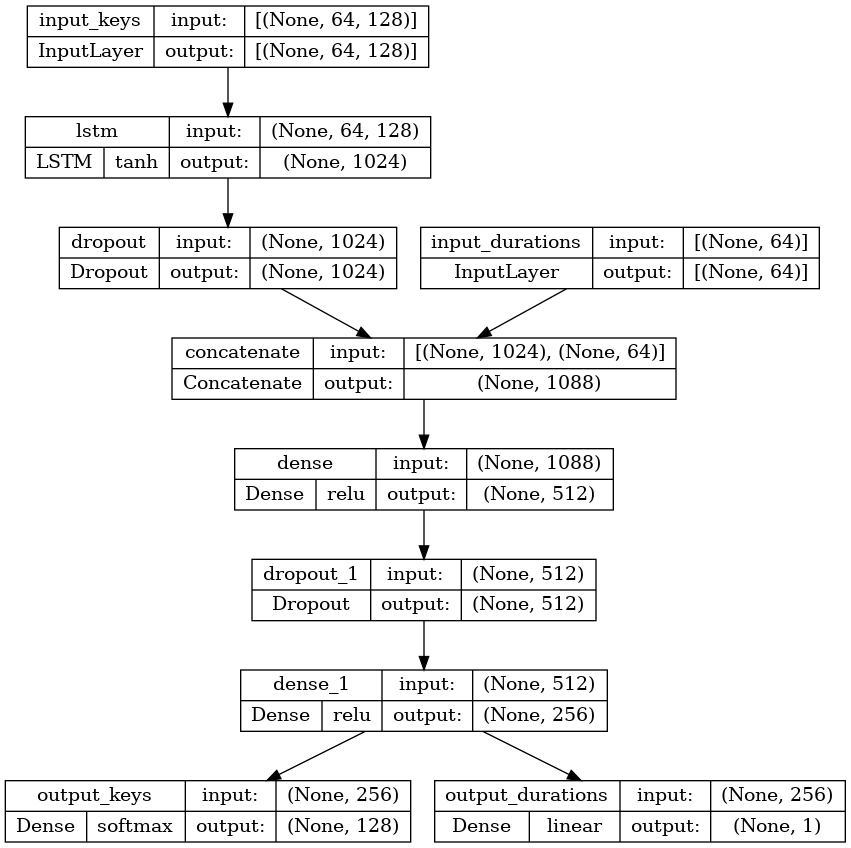

In [15]:
plot_model(model, show_shapes=True, show_dtype=True, show_layer_activations=True)

### 2.2 Training the neural network

The neural network is trained with a batch size of 1024, 600 epochs and 20% of the training data used for validation.

In [15]:
history = None
if model_source == "train":
    callbacks = [
        ModelCheckpoint(
            os.path.join(weights_dir, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        ),
        ModelCheckpoint(
            os.path.join(weights_dir, "weights.h5"),
            monitor='loss',
            verbose=0,
            save_best_only=True,
            mode='min'
        ),
        EarlyStopping(
            monitor='loss',
            restore_best_weights=True,
            patience = 25
        ),
        #LearningRateScheduler(lambda epoch: 0.01 / (epoch+1))
    ]

    model.save_weights(os.path.join(weights_dir, "weights.h5"))
    history = model.fit(
        [X_keys, X_durations], 
        [y_keys, y_durations],
        epochs = 600, 
        batch_size = 1024, 
        validation_split = 0.2, 
        callbacks = callbacks, 
        shuffle = True
    )
    serialize_save(history, "history")
else:
    model.load_weights(os.path.join(weights_dir, "weights.h5"))

Epoch 1/600


2024-03-12 15:17:18.052140: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-12 15:17:19.411584: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fdba8126950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-12 15:17:19.411668: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-03-12 15:17:19.417949: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710253039.497068    1315 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


167/167 [==============================] - ETA: 0s - loss: 0.2615 - output_keys_loss: 0.1629 - output_durations_loss: 0.0986 - output_keys_accuracy: 0.0222 - output_durations_accuracy: 0.0902

/home/miro/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


167/167 [==============================] - 35s 182ms/step - loss: 0.2615 - output_keys_loss: 0.1629 - output_durations_loss: 0.0986 - output_keys_accuracy: 0.0222 - output_durations_accuracy: 0.0902 - val_loss: 0.1355 - val_output_keys_loss: 0.0870 - val_output_durations_loss: 0.0485 - val_output_keys_accuracy: 0.0271 - val_output_durations_accuracy: 0.0808
Epoch 2/600
167/167 [==============================] - 27s 160ms/step - loss: 0.1272 - output_keys_loss: 0.0849 - output_durations_loss: 0.0423 - output_keys_accuracy: 0.0294 - output_durations_accuracy: 0.0949 - val_loss: 0.1259 - val_output_keys_loss: 0.0843 - val_output_durations_loss: 0.0416 - val_output_keys_accuracy: 0.0249 - val_output_durations_accuracy: 0.0830
Epoch 3/600
167/167 [==============================] - 27s 160ms/step - loss: 0.1237 - output_keys_loss: 0.0833 - output_durations_loss: 0.0404 - output_keys_accuracy: 0.0333 - output_durations_accuracy: 0.0956 - val_loss: 0.1249 - val_output_keys_loss: 0.0834 - val_o

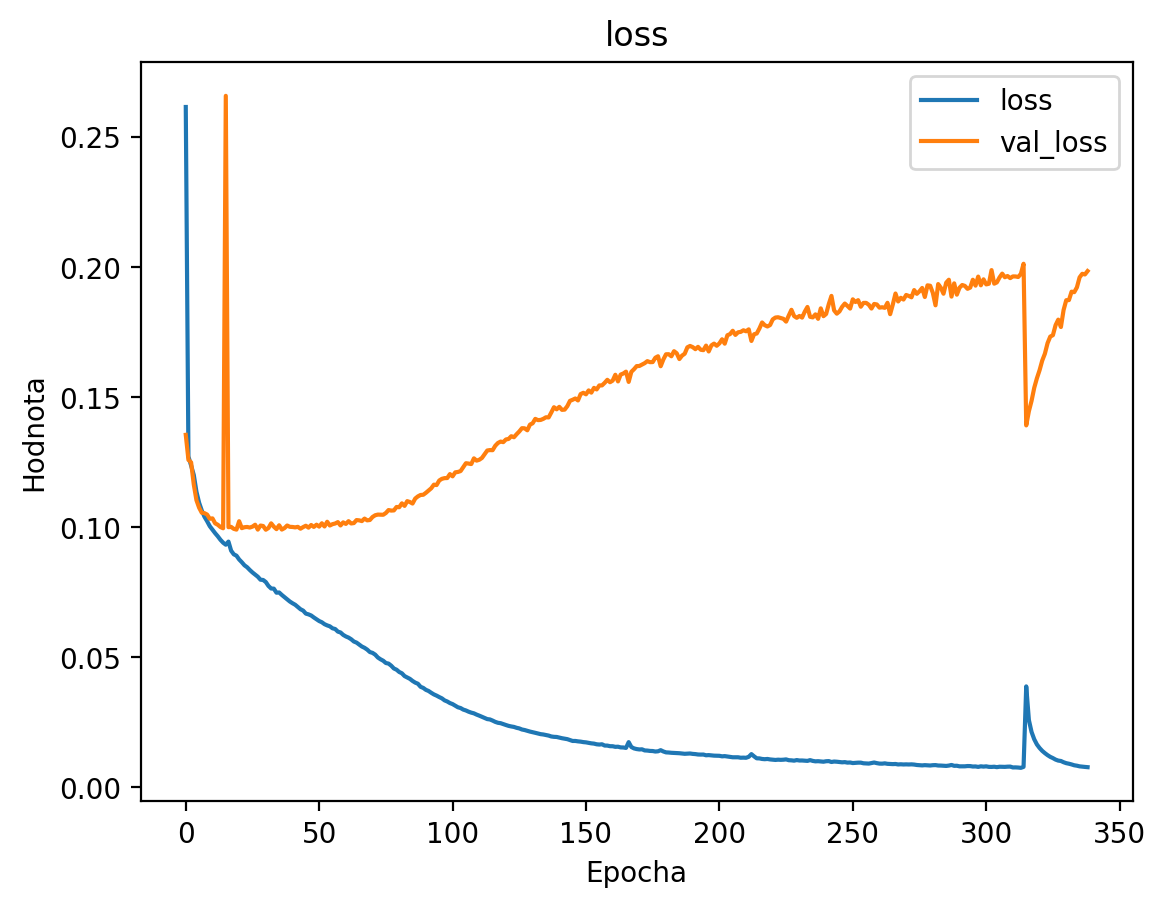

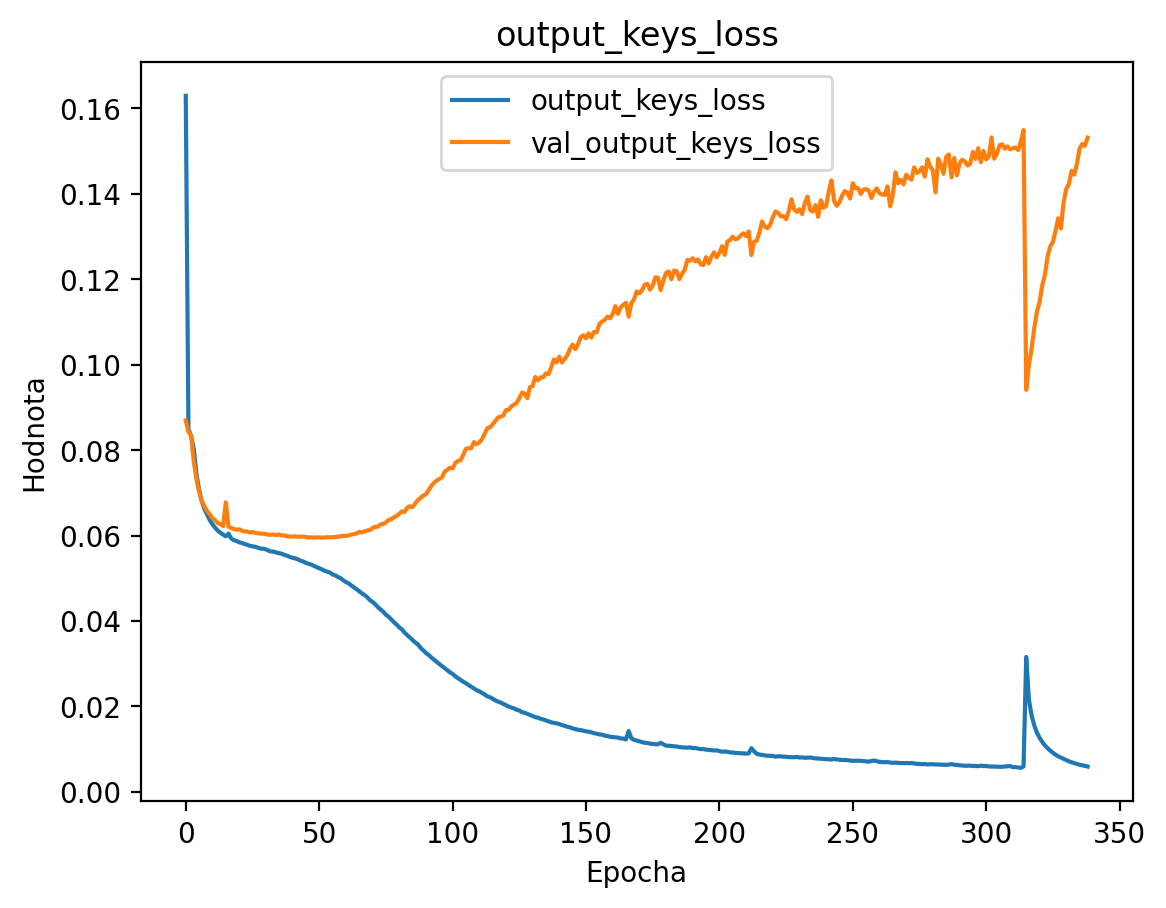

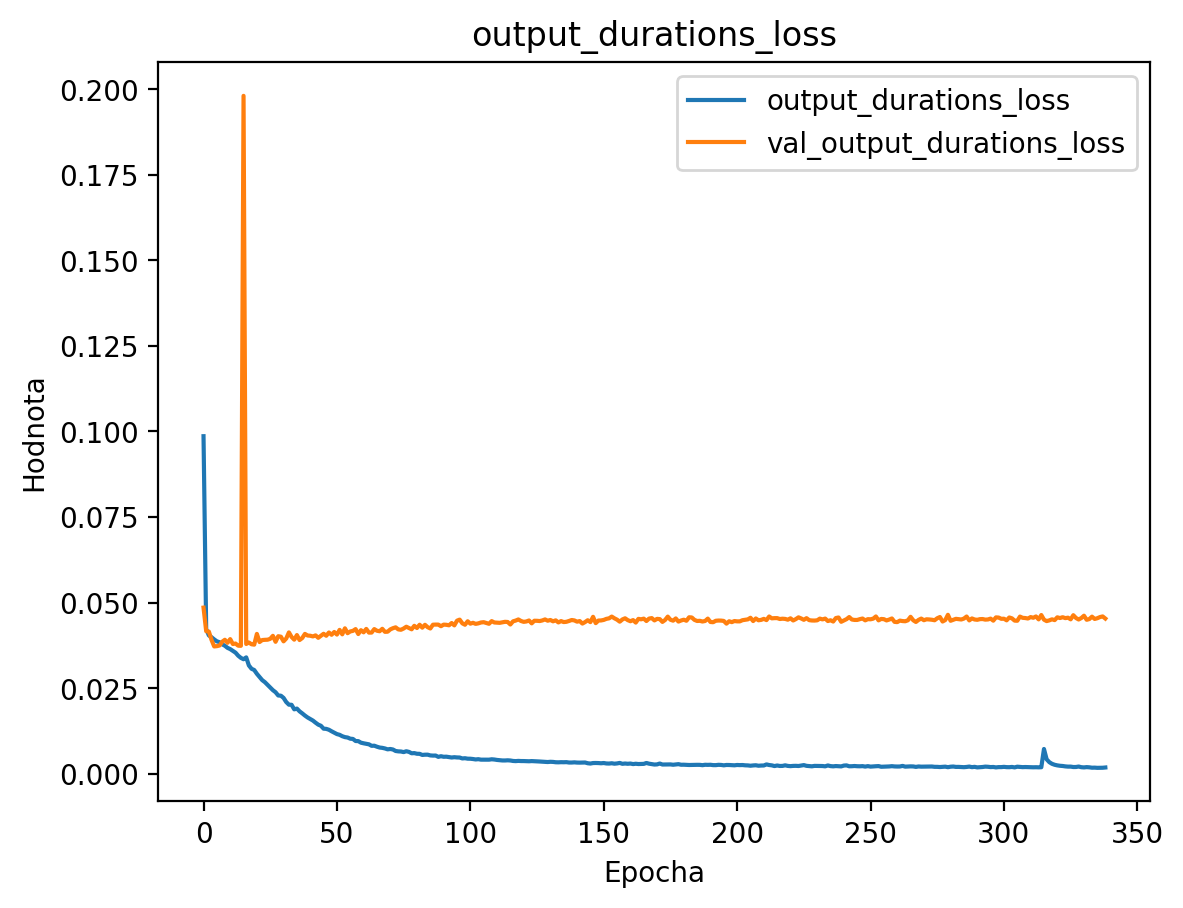

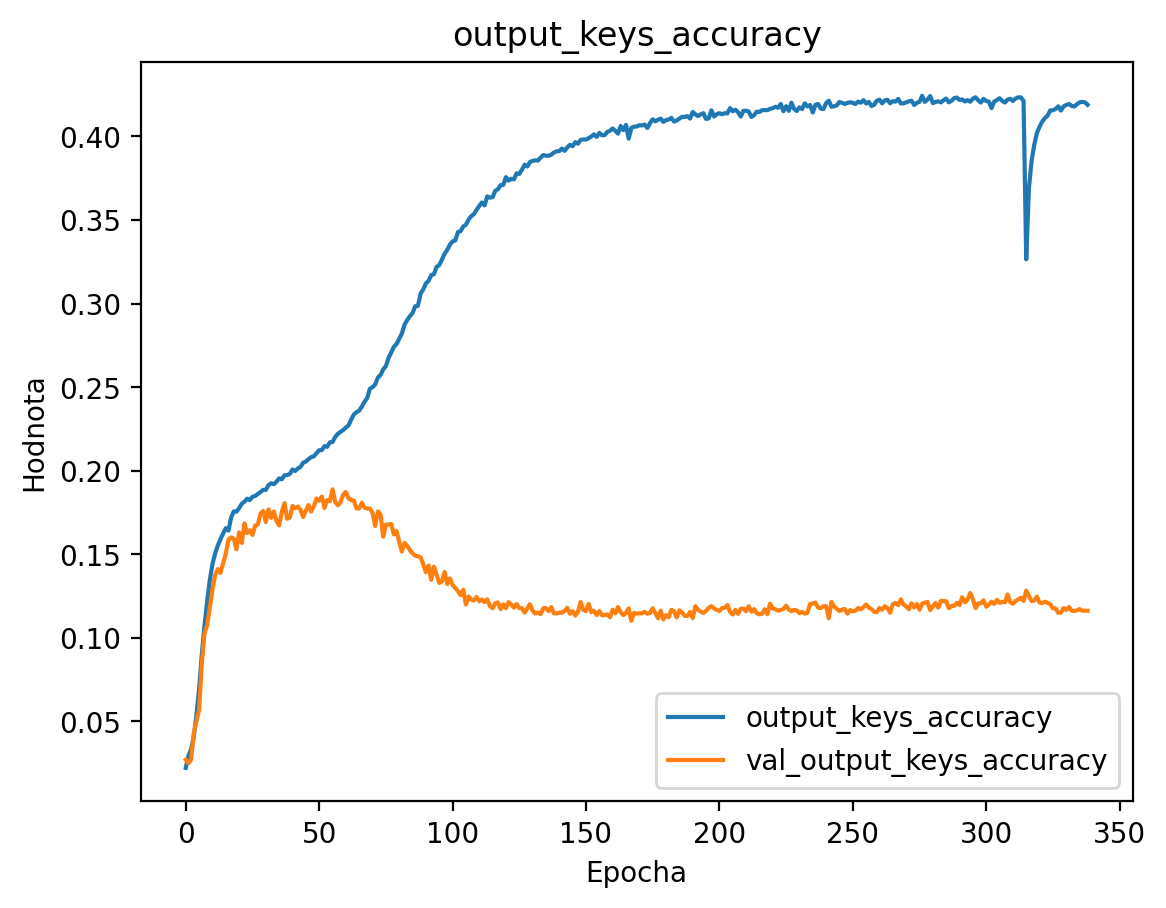

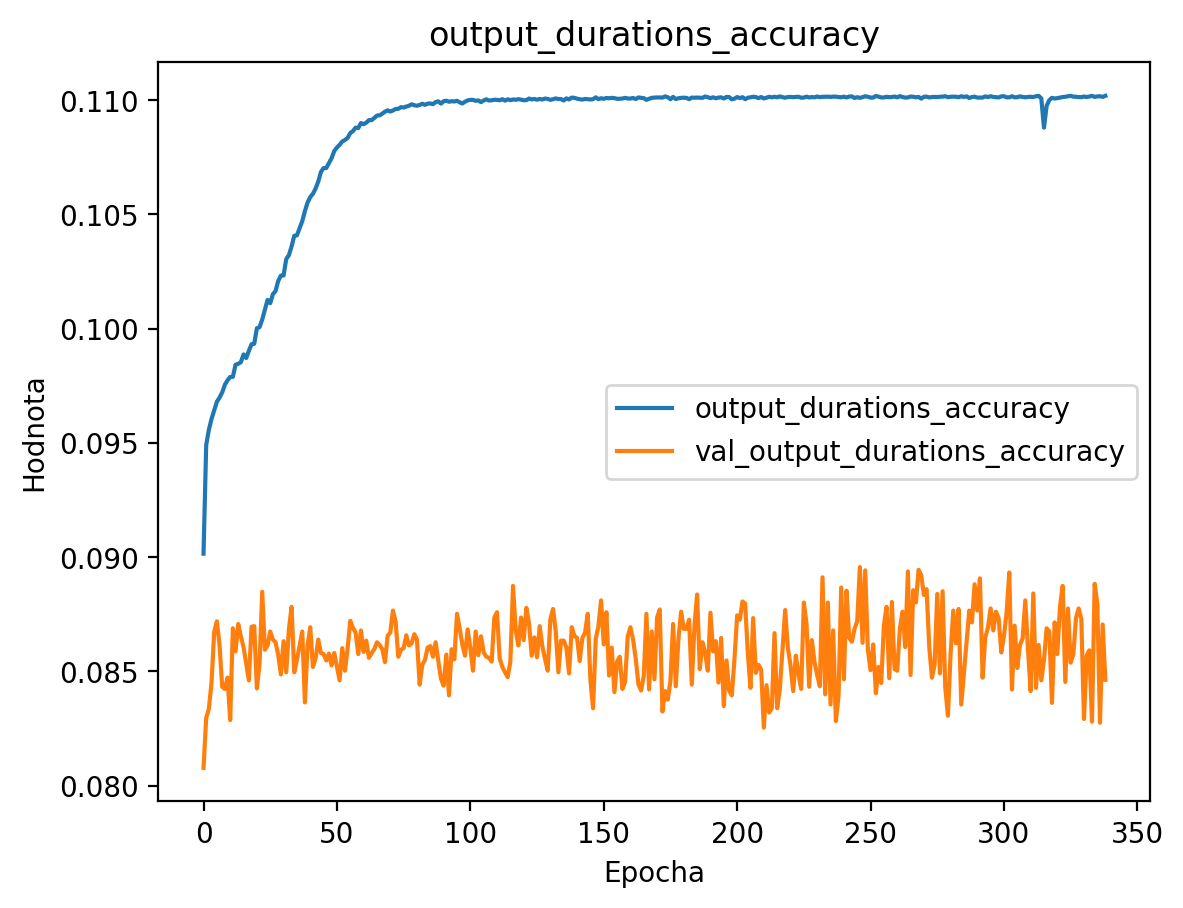

In [16]:
def plot_history(history):
    for key in list(history.history.keys()):
        if str(key).startswith("val"):
            continue
        plt.plot(history.history[key])
        plt.plot(history.history["val_"+key])
        plt.title(key)
        plt.xlabel("Epocha")
        plt.ylabel("Hodnota")
        plt.legend([key, "val_"+key])
        plt.savefig(os.path.join(plots_dir, key))
        plt.show()

try:
    if history is None:
        history = serialize_load("history")
except:
    print("No history file found")

if history is not None:
    plot_history(history)

# 3. Generating music using our NN

### 3.1 Helper functions - alternate input sources, purge repeated keys
Can be used as substitute for MIDI file should the music be random.

In [232]:
def generate_random_sequence(rows, key_threshold = 0.97):
    return (
        [np.array((np.random.rand(128,) > key_threshold), dtype=np.ubyte) for _ in range(rows)],
        list(np.random.rand(rows,)),
        default_tempo
    )

def generate_empty_sequence(rows):
    return (
        [np.zeros(notes_per_channel, dtype=np.ubyte) for _ in range(rows)],
        [0 for _ in range(rows)],
        default_tempo
    )

def remove_repeated_keys(keys, max_repeats = 2):
    row = np.zeros(notes_per_channel, dtype=np.ubyte)

    for k in keys:
        for i in range(notes_per_channel):
            if k[i]:
                if row[i] >= max_repeats:
                    k[i] = 0
                else:
                    row[i] += 1
            else:
                row[i] = 0

### 3.2 Process and cut off MIDI messages for prediction input

In [397]:
# input file name
pred_file = "__input/liz_et6.mid"
#pred_file = "__input/elise.mid"
#pred_file = "__input/liz_liebestraum.mid"

tempo_multiplier = 0.4

# how many repeated notes to tolerate
max_repeats = 2
# prediction "temperature", lower numbers result in a more chaotic prediction
output_threshold = 0.05

# row index where the song is cut off and our neural network continues
cutoff = 100
# how many rows to predict
pred_count = seq_len * 2

# input source
pred_in_keys, pred_in_durations, pred_tempo = midi_to_sequence(pred_file)                # use a midi file as input
#pred_in_keys, pred_in_durations, pred_tempo = generate_random_sequence(cutoff, 0.97)    # use a random sequence as input
#pred_in_keys, pred_in_durations, pred_tempo = generate_empty_sequence(cutoff)    # use an empty sequence as input

### 3.3 Make predictions using our NN

In [398]:
remove_repeated_keys(pred_in_keys, max_repeats)

In [399]:
pred_tempo *= tempo_multiplier
pad_sequence(pred_in_keys, pred_in_durations)
pred_cutoff = seq_len + cutoff
pred_in_keys = pred_in_keys[:pred_cutoff]
pred_in_durations = pred_in_durations[:pred_cutoff]
pred_out_keys = pred_in_keys.copy()
pred_out_durations = pred_in_durations.copy()

In [400]:
# count repeated keys and purge them
repeats = np.zeros(notes_per_channel, dtype=np.ubyte)

# make predictions
for i in range(pred_count):
    sys.stdout.write(f"\rPredicting {i+1}/{pred_count}")
    x = np.reshape([i for i in pred_out_keys[-seq_len:]], (1, seq_len, notes_per_channel))
    x1 = np.reshape(np.float32([i for i in pred_out_durations[-seq_len:]]), (1, seq_len))
    prediction = model.predict([x, x1], verbose=0)
    pred_keys = np.array(prediction[0][0] > output_threshold, dtype=np.ubyte)
    pred_keys[np.argmax(prediction[0][0])] = 1

    # purge repeating notes
    for j in range(notes_per_channel):
        if pred_keys[j] == 1:
            if repeats[j] >= max_repeats:
                pred_keys[j] = 0
                prediction[0][0][j] = 0
            else:
                repeats[j] += 1
        else:
            repeats[j] = 0

    # use argmax again if no keys are pressed
    if not pred_keys.all():
        pred_keys[np.argmax(prediction[0][0])] = 1

    pred_out_keys.append(pred_keys)
    pred_out_durations.append(m21.common.nearestMultiple(prediction[1][0][0], 0.0625)[0])

Predicting 128/128

In [401]:
# save input and prediction to .mid and .wav file
pred_input_midi = sequence_to_midi(pred_in_keys, pred_in_durations, pred_tempo)
pred_input_midi = save_midi_to_file(pred_input_midi, "pred_input", True)

pred_midi = sequence_to_midi(pred_out_keys, pred_out_durations, pred_tempo)
pred_midi = save_midi_to_file(pred_midi, "pred_output", True)

fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/miro/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'pred_input.wav'..


fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter '/home/miro/.fluidsynth/default_sound_font.sf2' not a SoundFont or MIDI file or error occurred identifying it.


FluidSynth runtime version 2.2.5
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'pred_output.wav'..


In [402]:
Counter(list(map(lambda x: x.duration.quarterLength, pred_midi)))

Counter({0.25: 181,
         0.0: 65,
         Fraction(1, 6): 21,
         Fraction(1, 12): 18,
         0.3125: 5,
         0.75: 2,
         0.1875: 1})

### 3.4 Plots for input

In [403]:
pred_input_midi.plot("pianoroll")
pred_input_midi.plot("histogram", "pitchClass")
pred_input_midi.plot("histogram", "pitch")

### 3.5 Plots for output

In [404]:
pred_midi.plot("pianoroll")
pred_midi.plot("histogram", "pitchClass")
pred_midi.plot("histogram", "pitch")